# DIISCO Tutorial

A tutorial applying DIISCO to longitudinal samples from a CAR-T/leukemia co-culture experiment.

In [1]:
cd ..

/Users/shouvikmani/Desktop/DIISCO/DIISCO/diisco


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torch
torch.set_default_dtype(torch.float64)

from diisco import DIISCO
import diisco.names as names

## Load and explore data

Load cell type proportions over time

In [3]:
df = pd.read_csv('../../data/CAR-T ratios and umap/CARC_ratios_processed.pkl', 
                 index_col='Hours post co-culture')
cell_types = ['MEC1 cells', 'Other CD8+ T cells', 'Activated T cells', 'Exhausted T cells']
df.columns = cell_types + ['total_cells_per_sample']
df

,MEC1 cells,Other CD8+ T cells,Activated T cells,Exhausted T cells,total_cells_per_sample
Hours post co-culture,,,,,
0.000000,0.000000,0.000000,1.000000,0.000000,3.0
0.083333,0.773585,0.047170,0.179245,0.000000,106.0
0.250000,0.726852,0.055556,0.212963,0.004630,216.0
0.500000,0.691489,0.063830,0.234043,0.010638,188.0
1.000000,0.493363,0.030973,0.466814,0.008850,452.0
2.000000,0.613084,0.026168,0.349533,0.011215,535.0
4.000000,0.583333,0.010563,0.373239,0.032864,852.0
8.500000,0.388668,0.036282,0.072565,0.502485,2012.0
12.500000,0.266527,0.042497,0.093914,0.597062,1906.0


Check: proportions sum up to 1

In [4]:
df.iloc[:, :4].sum(axis=1)

Hours post co-culture
0.000000     1.0
0.083333     1.0
0.250000     1.0
0.500000     1.0
1.000000     1.0
2.000000     1.0
4.000000     1.0
8.500000     1.0
12.500000    1.0
20.500000    1.0
dtype: float64

Visualize cell type proportions over time

Text(0.5, 1.05, 'Cell type proportions')

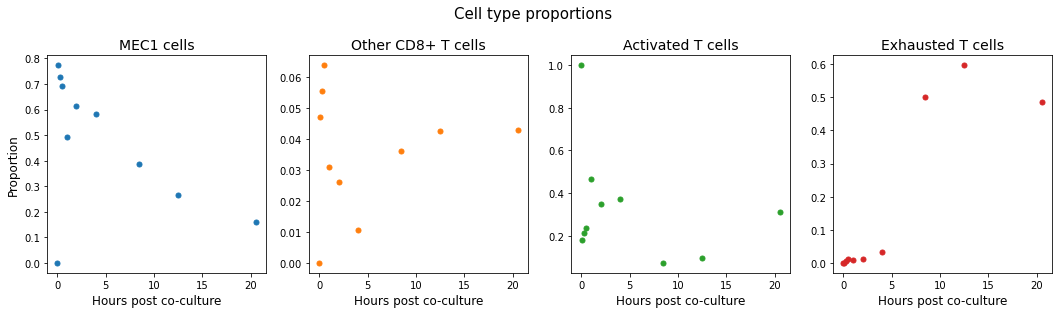

In [5]:
cell_type_color = [('MEC1 cells', 'tab:blue'), 
                   ('Other CD8+ T cells', 'tab:orange'), 
                   ('Activated T cells', 'tab:green'),
                   ('Exhausted T cells', 'tab:red')]

fig, axes = plt.subplots(1, 4, figsize=(18, 4))
for i, cell_type in enumerate(cell_types):
    ax = axes[i]
    ax.scatter(df.index, df[cell_type], c=cell_type_color[i][1], s=25)
    ax.set_title(f'{cell_type_color[i][0]}', fontsize=14)
    ax.set_xlabel('Hours post co-culture', fontsize=12)
    if i==0: ax.set_ylabel('Proportion', fontsize=12)
plt.suptitle('Cell type proportions', fontsize=15, y=1.05)

Create DIISCO interaction prior - how much do we expect cell types to interact with each other?

Text(24.0, 0.5, 'Target cluster')

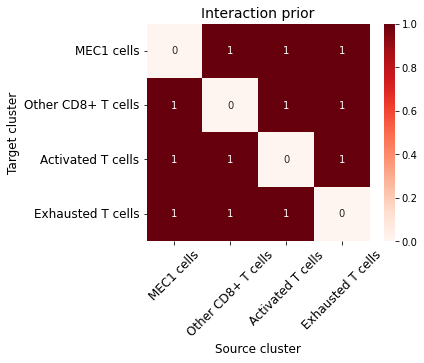

In [6]:
W_prior_variance = np.array([[0, 1, 1, 1], 
                             [1, 0, 1, 1], 
                             [1, 1, 0, 1], 
                             [1, 1, 1, 0]])

plt.figure(figsize=(5, 4))
ax = sns.heatmap(W_prior_variance, cmap="Reds", annot=True)
ax.set_yticklabels(cell_types, fontsize=12)
ax.set_xticklabels(cell_types, fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.title('Interaction prior', fontsize=14)
plt.xlabel('Source cluster', fontsize=12)
plt.ylabel('Target cluster', fontsize=12)

Convert data into `torch.tensor` for DIISCO

In [7]:
timepoints = torch.tensor(df.index.values.reshape(-1, 1))
proportions = torch.tensor(df[cell_types].values)
prior_matrix = torch.tensor(W_prior_variance)
n_timepoints, n_cell_types = proportions.shape

print('timepoints.shape:', timepoints.shape)
print('cell_types.shape:', proportions.shape)

timepoints.shape: torch.Size([10, 1])
cell_types.shape: torch.Size([10, 4])


Scale (z-score) the data for DIISCO

In [8]:
# z score the proportions
proportions_mean = proportions.mean(dim=0)
proportions_std = proportions.std(dim=0)
proportions = (proportions - proportions_mean) / (proportions_std)

def unscale(proportions, proportions_mean, proportions_std, cluster_index): 
    return np.clip(proportions * 
                   proportions_std.detach().numpy()[cluster_index] + 
                   proportions_mean.detach().numpy()[cluster_index], 
                   0, None)

## Run DIISCO

In [9]:
hyperparams = {
    names.LENGTHSCALE_F: 6.5,
    names.LENGTHSCALE_W: 6.5,
    names.SIGMA_F: 0.5,
    names.VARIANCE_F: 1,
    names.SIGMA_W: 0.1,
    names.VARIANCE_W: 1,
    names.SIGMA_Y: 0.5,
}

Fit DIISCO model

In [10]:
model = DIISCO(lambda_matrix=prior_matrix, hypers_init_vals=hyperparams, verbose=True)
model.fit(timepoints, 
          proportions, 
          n_iter=10000, 
          lr=0.00005,
          hypers_to_optim=[], 
          guide="MultivariateNormalFactorized")

<bound method DIISCO._factorized_normal_guide of <diisco.diisco.DIISCO object at 0x144729790>>
[iteration 0001] loss: 2663.7146
[iteration 0101] loss: 1534.2345
[iteration 0201] loss: 1551.2712
[iteration 0301] loss: 1406.8158
[iteration 0401] loss: 1332.4420
[iteration 0501] loss: 1267.6490
[iteration 0601] loss: 1215.3629
[iteration 0701] loss: 1195.0707
[iteration 0801] loss: 1192.3703
[iteration 0901] loss: 1234.2334
[iteration 1001] loss: 1132.1707
[iteration 1101] loss: 1080.3374
[iteration 1201] loss: 1105.2730
[iteration 1301] loss: 1058.5674
[iteration 1401] loss: 1167.0685
[iteration 1501] loss: 1009.5984
[iteration 1601] loss: 1025.3740
[iteration 1701] loss: 991.5800
[iteration 1801] loss: 986.7161
[iteration 1901] loss: 999.5333
[iteration 2001] loss: 1044.8851
[iteration 2101] loss: 968.6098
[iteration 2201] loss: 962.1957
[iteration 2301] loss: 947.9805
[iteration 2401] loss: 953.7092
[iteration 2501] loss: 939.6084
[iteration 2601] loss: 970.0663
[iteration 2701] loss: 

Make sure that loss converges

Text(0.5, 0, 'Number of epochs')

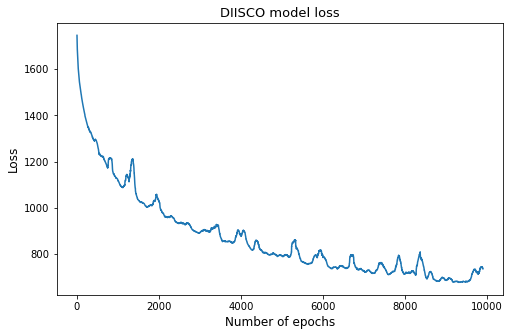

In [11]:
start = 0
loss_moving_avg = np.convolve(model.losses[start:], np.ones(100)/100, 'valid')

plt.figure(figsize=(8, 5))
plt.plot(loss_moving_avg)
plt.title('DIISCO model loss', fontsize=13)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Number of epochs', fontsize=12)

Sample predicted proportions and interactions from DIISCO model posterior 

In [12]:
predict_timepoints = torch.linspace(timepoints.min(), timepoints.max(), 100).reshape(-1, 1)
f_samples_predict, W_samples_predict, y_samples_predict = \
    model.sample(predict_timepoints, n_samples=10000, include_emission_variance=True)
print(y_samples_predict.shape)
print(W_samples_predict.shape)

100%|██████████████████████████████████████████| 10000/10000 [02:44<00:00, 60.94it/s]


torch.Size([10000, 100, 4])
torch.Size([10000, 100, 4, 4])


Visualize DIISCO predicted proportions

Text(0.5, 1.05, 'DIISCO predicted cell type proportions')

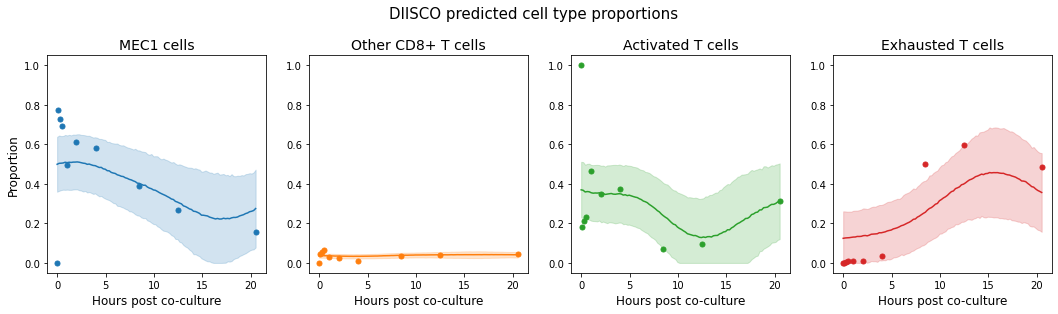

In [13]:
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
for i, cell_type in enumerate(cell_types):
    cell_type_samples = y_samples_predict[:, :, i]
    mean = unscale(cell_type_samples.mean(axis=0), proportions_mean, proportions_std, i)
    x = predict_timepoints.squeeze().numpy()
    percentile_75 = unscale(np.percentile(cell_type_samples, 84, axis=0), 
                            proportions_mean, proportions_std, i)
    percentile_25 = unscale(np.percentile(cell_type_samples, 16, axis=0), 
                            proportions_mean, proportions_std, i)
    ax = axes[i]
    line = ax.plot(x, mean, c=cell_type_color[i][1])
    ax.fill_between(x, percentile_25, percentile_75, color=cell_type_color[i][1], alpha=0.2)
    ax.scatter(df.index, df[cell_type], c=cell_type_color[i][1], s=25)
    ax.set_title(f'{cell_type_color[i][0]}', fontsize=14)
    ax.set_xlabel('Hours post co-culture', fontsize=12)
    if i==0: ax.set_ylabel('Proportion', fontsize=12)
    ax.set_ylim([-0.05, 1.05])
plt.suptitle('DIISCO predicted cell type proportions', fontsize=15, y=1.05)

Visualize DIISCO predicted interactions (mean)

Text(24.0, 0.5, 'Target cluster')

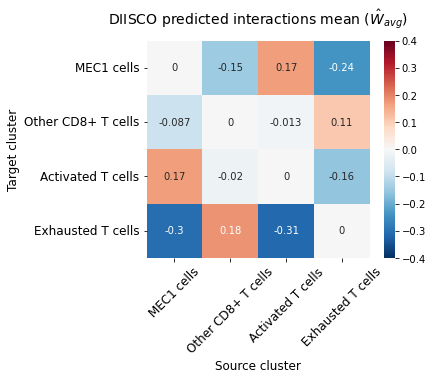

In [19]:
plt.figure(figsize=(5, 4))
W_avg_over_time = W_samples_predict.mean(axis=(0, 1)).detach().numpy()
ax = sns.heatmap(W_avg_over_time, cmap="RdBu_r", annot=True, 
                 vmax=0.4, vmin=-0.4, center=0)
ax.set_yticklabels(cell_types, fontsize=12)
ax.set_xticklabels(cell_types, fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.title('DIISCO predicted interactions mean ($\hat{W}_{avg})$', fontsize=14, y=1.05)
plt.xlabel('Source cluster', fontsize=12)
plt.ylabel('Target cluster', fontsize=12)

Visualize DIISCO predicted interactions (temporal)

Text(0.5, 0, 'Hours post co-culture')

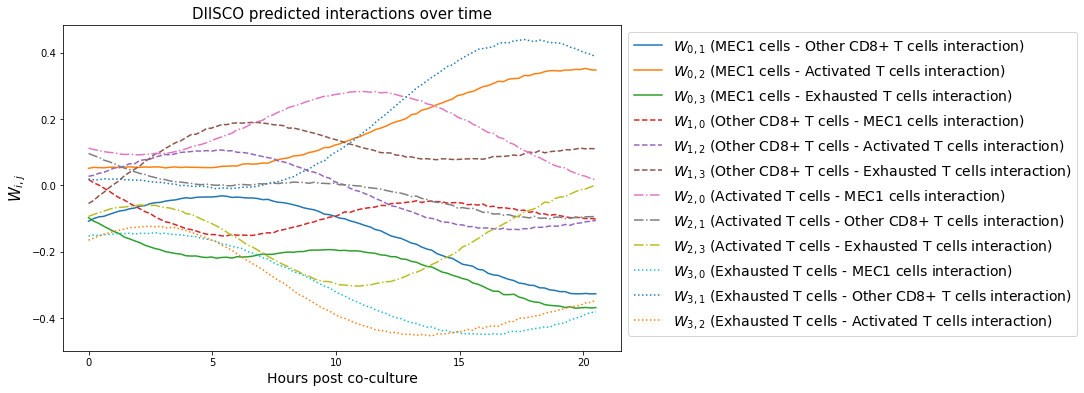

In [20]:
plt.figure(figsize=(10, 6))
linestyles = ['-', '--', '-.', ':']
for i, cell_type_i in enumerate(cell_types):
    for j, cell_type_j in enumerate(cell_types):
        if i != j:
            plt.plot(predict_timepoints, 
                     W_samples_predict.mean(axis=0)[:, i, j].detach().numpy(),
                     linestyle=linestyles[i],
                     label='$W_{%s,%s}$ (%s - %s interaction)' % (i, j, cell_type_i, cell_type_j))
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=14)
plt.title('DIISCO predicted interactions over time', fontsize=15)
plt.ylabel('$W_{i, j}$', fontsize=15)
plt.xlabel('Hours post co-culture', fontsize=14)

## DIISCO interaction network

In [46]:
W_avg_edge_list = []

for row in range(W_avg_over_time.shape[0]):
    for col in range(W_avg_over_time.shape[0]):
        W_avg_edge_list.append({
            'source': cell_types[col],
            'target': cell_types[row],
            'Interaction weight': W_avg_over_time[row, col],
            'abs(Interaction weight)': np.abs(W_avg_over_time[row, col]),
            'sign(Interaction weight)': np.sign(W_avg_over_time[row, col])
        })

W_avg_edge_list_df = pd.DataFrame(W_avg_edge_list)
W_avg_edge_list_df = W_avg_edge_list_df[W_avg_edge_list_df['source'] != W_avg_edge_list_df['target']]
W_avg_edge_list_df.head()

,source,target,Interaction weight,abs(Interaction weight),sign(Interaction weight)
1,Other CD8+ T cells,MEC1 cells,-0.145894,0.145894,-1.0
2,Activated T cells,MEC1 cells,0.167363,0.167363,1.0
3,Exhausted T cells,MEC1 cells,-0.238653,0.238653,-1.0
4,MEC1 cells,Other CD8+ T cells,-0.086875,0.086875,-1.0
6,Activated T cells,Other CD8+ T cells,-0.012770,0.012770,-1.0


In [47]:
y_preds_avg_over_samples = y_samples_predict.mean(axis=0).numpy()
y_preds_avg_over_time = y_preds_avg_over_samples.mean(axis=0)
y_preds_avg_over_time = [unscale(y, proportions_mean, proportions_std, i) 
                         for i, y in enumerate(y_preds_avg_over_time)]
y_preds_df = pd.DataFrame(y_preds_avg_over_time, 
                          index=cell_types, 
                          columns=['Inferred cluster proportion'])
y_preds_df.index.name = 'id'
y_preds_df = y_preds_df.reset_index()
y_preds_df

,id,Inferred cluster proportion
0,MEC1 cells,0.362919
1,Other CD8+ T cells,0.038628
2,Activated T cells,0.253362
3,Exhausted T cells,0.300930


In [42]:
import py4cytoscape as p4c
p4c.cytoscape_ping()
p4c.cytoscape_version_info()

You are connected to Cytoscape!


{'apiVersion': 'v1',
 'cytoscapeVersion': '3.9.1',
 'automationAPIVersion': '1.6.0',
 'py4cytoscapeVersion': '1.5.0'}

Applying default style...
Applying preferred layout
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.


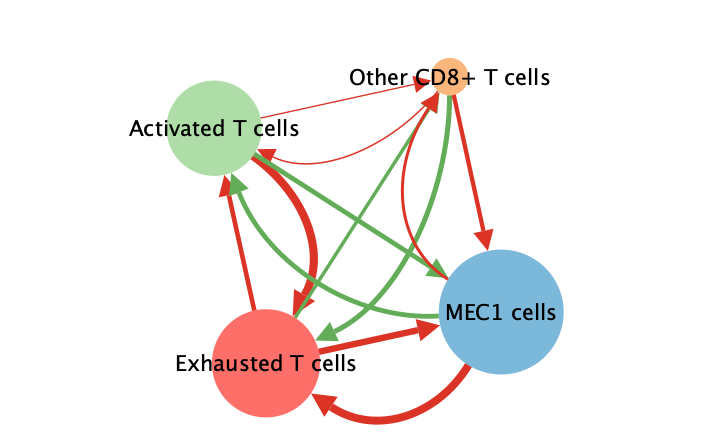

In [54]:
p4c.create_network_from_data_frames(nodes=y_preds_df, 
                                    edges=W_avg_edge_list_df, 
                                    title="CAR-T", 
                                    collection="CAR-T")

# Default styles
p4c.set_node_shape_default('ELLIPSE')
p4c.set_node_width_default(20)
p4c.set_node_height_default(20)
p4c.set_node_font_size_default(8)
p4c.set_edge_target_arrow_shape_default('DELTA_SHORT_1')

# Map style properties to node/edge attributes
p4c.set_node_color_mapping(table_column='shared name', 
                           table_column_values=['MEC1 cells', 'Other CD8+ T cells', 
                                                'Activated T cells','Exhausted T cells'], 
                           colors=['#7CB8DA', '#FAB67B', '#AEDDA7', '#FF6F69'], 
                           mapping_type='d')
p4c.set_node_size_mapping('SUID',
                          list(p4c.get_table_columns()['SUID']),
                          sizes=list(p4c.get_table_columns()['Inferred cluster proportion']*100 + 10))
p4c.set_edge_color_mapping(table_column='sign(Interaction weight)',
                           table_column_values=[-1.0, 1.0],
                           colors=['#DB3427', '#63AD58'])
p4c.set_edge_target_arrow_color_mapping(table_column='sign(Interaction weight)',
                                        table_column_values=[-1.0, 1.0],
                                        colors=['#DB3427', '#63AD58'])
p4c.set_edge_line_width_mapping(**p4c.gen_edge_width_map('abs(Interaction weight)', 
                                                         p4c.scheme_c_number_continuous(0.5, 3)))

p4c.set_network_center_bypass(0, 0)
p4c.set_network_zoom_bypass(3)
p4c.notebook_export_show_image(zoom=90)